# Cube and Data Warehouse mini Demo
This aims to implement a cube and do presentation
## Cube

In [1]:
import atoti as tt

Welcome to Atoti 0.8.10!

By using this community edition, you agree with the license available at https://docs.atoti.io/latest/eula.html.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

Atoti collects telemetry data, which is used to help understand how to improve the product.
If you don't wish to send usage data, you can request a trial license at https://www.atoti.io/evaluation-license-request.

You can hide this message by setting the `ATOTI_HIDE_EULA_MESSAGE` environment variable to True.


In [2]:
session = tt.Session(
    user_content_storage=".content",
    port=9092,
    java_options=["-Xms1G", "-Xmx10G"]
)

- It imports the atoti library using the alias tt.
- It creates a session object using tt.Session.
- The `user_content_storage=".content"` parameter specifies the directory or location where user content will be stored. This could include things like data files, configurations, or any other persistent data related to the session.
- The `port=9092` parameter specifies the port number on which the session will listen for incoming connections or requests. This port is important for communication between the Atoti server and client applications.
- The `java_options=["-Xms1G", "-Xmx10G"]` parameter specifies Java Virtual Machine (JVM) options. In this case, it's setting the initial heap size (-Xms1G) to 1 gigabyte and the maximum heap size (-Xmx10G) to 10 gigabytes. This is important for controlling memory allocation for the Atoti server.

In [3]:
db_name = "AdventureworksDWDemo"
db_user = "postgres"
db_password = "postgres"  # Update with your password
db_host = "pgdb"  # Update if your DB is hosted elsewhere
db_port = "5432"

jdbc_url = f"jdbc:postgresql://{db_host}:{db_port}/{db_name}?user={db_user}&password={db_password}"

## Load Data to Atoti

In [4]:
product_sales_table = session.read_sql(
    "SELECT * FROM factproductsales",
    keys=["transactionid"],
    table_name="ProductSales",
    url=jdbc_url,
)



- `session.read_sql()`: This method is used to read data from a SQL database into an Atoti session.

- `"SELECT * FROM factproductsales"`: This is the SQL query that specifies the data to be retrieved from the database. It selects all columns (`*`) from the table named `factproductsales`.

- `keys=["transactionid"]`: This parameter specifies the primary key or keys of the table. In this case, it seems that `transactionid` is the primary key of the `factproductsales` table.

- `table_name="ProductSales"`: This parameter specifies the name to be assigned to the table within the Atoti session where the data will be loaded. Here, the table will be named `ProductSales`.

- `url=jdbc_url`: This parameter specifies the JDBC URL used to connect to the SQL database. `jdbc_url` should be a variable containing the JDBC URL of the database.

So, this code retrieves data from the `factproductsales` table in the SQL database specified by the JDBC URL, loads it into the Atoti session, and assigns the table the name `ProductSales` within the session. The primary key of the table is `transactionid`.

In [5]:
customer_table = session.read_sql(
    "SELECT * FROM dimcustomer",
    keys=["customerid"],
    table_name="Customer",
    url=jdbc_url)

In [6]:
product_table = session.read_sql(
    "SELECT * FROM dimproduct",
    keys=["productkey"],
    table_name="Product",
    url=jdbc_url
)

In [7]:
sales_person_table = session.read_sql(
    "SELECT * FROM dimsalesperson",
    keys=["salespersonid"],
    table_name="SalesPerson",
    url=jdbc_url
)

In [8]:
stores_table = session.read_sql(
    "SELECT * FROM dimstores",
    keys=["storeid"],
    table_name="Stores",
    url=jdbc_url
)

In [9]:
product_sales_table.head()

,salesinvoicenumber,storeid,customerid,productid,salespersonid,quantity,salestotalcost,productactualcost,deviation
transactionid,,,,,,,,,
7,3,1,3,3,2,1.0,43.5,42.0,1.5
15,6,1,3,5,2,1.0,139.0,135.0,4.0
23,10,1,3,4,2,3.0,60.0,54.0,6.0
8,3,1,3,4,2,3.0,60.0,54.0,6.0
16,7,2,1,4,3,3.0,60.0,54.0,6.0


## Implement a Star Schema

In [10]:
product_sales_table.join(customer_table, product_sales_table["customerid"] == customer_table["customerid"])

In [11]:
product_sales_table.join(product_table, product_sales_table["productid"] == product_table["productkey"])

In [12]:
product_sales_table.join(sales_person_table,
                         product_sales_table["salespersonid"] == sales_person_table["salespersonid"])


Each join links the `product_sales_table` with another table using a specific column (e.g., `customerid`, `productid`, `salespersonid`, `storeid`). These joins effectively combine data from multiple tables into a single dataset, allowing for more comprehensive analysis within the Atoti session.

In [13]:
product_sales_table.join(stores_table, product_sales_table["storeid"] == stores_table["storeid"])

## Draw a Schema

In [14]:
session.tables.schema

```mermaid
erDiagram
  "Customer" {
    _ int PK "customerid"
    _ String "customeraltid"
    _ String "customername"
    _ String "gender"
  }
  "SalesPerson" {
    _ int PK "salespersonid"
    _ String "salespersonaltid"
    _ String "salespersonname"
    nullable int "storeid"
    _ String "city"
    _ String "state"
    _ String "country"
  }
  "Product" {
    _ int PK "productkey"
    _ String "productaltkey"
    _ String "productname"
    nullable double "productactualcost"
    nullable double "productsalescost"
  }
  "Stores" {
    _ int PK "storeid"
    _ String "storealtid"
    _ String "storename"
    _ String "storelocation"
    _ String "city"
    _ String "state"
    _ String "country"
  }
  "ProductSales" {
    _ long PK "transactionid"
    nullable int "salesinvoicenumber"
    nullable int "storeid"
    nullable int "customerid"
    nullable int "productid"
    nullable int "salespersonid"
    nullable double "quantity"
    nullable double "salestotalcost"
    nullable double "productactualcost"
    nullable double "deviation"
  }
  "ProductSales" }o--o| "Product" : "`productid` == `productkey`"
  "ProductSales" }o--o| "Customer" : "`customerid` == `customerid`"
  "ProductSales" }o--o| "SalesPerson" : "`salespersonid` == `salespersonid`"
  "ProductSales" }o--o| "Stores" : "`storeid` == `storeid`"
```


In [15]:
cube = session.create_cube(product_sales_table)

In [16]:
cube

In [17]:
hierarchies, levels, measures = cube.hierarchies, cube.levels, cube.measures

In data warehousing, levels and hierarchies are fundamental concepts used to organize and structure data within dimensional models. Here's a breakdown of each concept:

1. **Levels**:
   - In the context of data warehousing, a "level" refers to a specific position within a hierarchy.
   - Levels represent the different granularities or degrees of detail within a dimension.
   - For example, in a time dimension, levels could include Year, Quarter, Month, Week, and Day. Each level represents a different level of granularity or detail within the time dimension.

2. **Hierarchies**:
   - A "hierarchy" represents the logical structure that arranges levels in a specific order or relationship.
   - Hierarchies define the parent-child relationships between different levels within a dimension.
   - Typically, hierarchies have a top-down structure, with higher levels encompassing lower levels.
   - In a time dimension, for instance, the Year level would be at the top of the hierarchy, followed by Quarter, Month, Week, and Day levels, with each level being subordinate to the one above it.

In summary, levels represent the individual positions or granularities within a dimension, while hierarchies define the logical relationships and order among these levels. Together, levels and hierarchies provide a structured way to organize and analyze data within dimensional models, facilitating efficient querying and reporting in data warehousing environments.

In [18]:
# original hierarchies
hierarchies

{('Stores', 'storename'): <atoti.hierarchy.Hierarchy object at 0x7fffb04f4590>, ('Stores', 'state'): <atoti.hierarchy.Hierarchy object at 0x7fffb0502b50>, ('Product', 'productname'): <atoti.hierarchy.Hierarchy object at 0x7fffb0502c90>, ('SalesPerson', 'city'): <atoti.hierarchy.Hierarchy object at 0x7fffb0502d90>, ('Product', 'productaltkey'): <atoti.hierarchy.Hierarchy object at 0x7fffb0502e90>, ('SalesPerson', 'salespersonaltid'): <atoti.hierarchy.Hierarchy object at 0x7fffb0502fd0>, ('Stores', 'storealtid'): <atoti.hierarchy.Hierarchy object at 0x7fffb0503110>, ('Stores', 'city'): <atoti.hierarchy.Hierarchy object at 0x7fffb0503250>, ('ProductSales', 'transactionid'): <atoti.hierarchy.Hierarchy object at 0x7fffb0503390>, ('Customer', 'customername'): <atoti.hierarchy.Hierarchy object at 0x7fffb05034d0>, ('SalesPerson', 'salespersonname'): <atoti.hierarchy.Hierarchy object at 0x7fffb0503610>, ('SalesPerson', 'country'): <atoti.hierarchy.Hierarchy object at 0x7fffb0503750>, ('Customer', 'customeraltid'): <atoti.hierarchy.Hierarchy object at 0x7fffb0503890>, ('Stores', 'storelocation'): <atoti.hierarchy.Hierarchy object at 0x7fffb05039d0>, ('SalesPerson', 'state'): <atoti.hierarchy.Hierarchy object at 0x7fffb0503b10>, ('Stores', 'country'): <atoti.hierarchy.Hierarchy object at 0x7fffb0503c50>, ('Customer', 'gender'): <atoti.hierarchy.Hierarchy object at 0x7fffb0503d90>}

In [19]:
# original levels
levels

In [20]:
levels

In [21]:
# dimensions
# Customer: CustomerName, Gender
# SalesPerson: SalesPersonName, City, State, Country
# Product: ProductName
# Store: StoreName, City, State

In [22]:
hierarchies["Customer"] = [levels["customername"], levels["gender"]]

In [23]:
hierarchies["Product"] = [levels["productname"]]

In [24]:
hierarchies["SalesPerson"] = [levels["salespersonname"], levels[('SalesPerson', 'city', 'city')],
                              levels[('SalesPerson', 'state', 'state')], levels[('SalesPerson', 'country', 'country')]]

In [25]:
hierarchies["Stores"] = [levels[('Stores', 'storename', 'storename')], levels[('Stores', 'city', 'city')],
                         levels[('Stores', 'state', 'state')], levels[('Stores', 'country', 'country')]]

1. **Customer Hierarchy**:
   - This hierarchy has two levels: `gender` and `customername`. It suggests organizing customers based on their gender and then further subcategorizing them by their names.

2. **Product Hierarchy**:
   - This hierarchy seems to have only one level: `productname`. It implies organizing products solely based on their names.

3. **SalesPerson Hierarchy**:
   - This hierarchy is more complex and has multiple levels:
     - `salespersonname`: Organizing salespersons by their names.
     - `('SalesPerson', 'city', 'city')`: Organizing salespersons by the cities they operate in.
     - `('SalesPerson', 'state', 'state')`: Organizing salespersons by the states they operate in.
     - `('SalesPerson', 'country', 'country')`: Organizing salespersons by the countries they operate in.

4. **Stores Hierarchy**:
   - Similar to the SalesPerson hierarchy, this one also has multiple levels:
     - `('Stores', 'storename', 'storename')`: Organizing stores by their names.
     - `('Stores', 'city', 'city')`: Organizing stores by the cities they are located in.
     - `('Stores', 'state', 'state')`: Organizing stores by the states they are located in.
     - `('Stores', 'country', 'country')`: Organizing stores by the countries they are located in.

These hierarchies define the logical relationships between different levels within each dimension. They provide a structured way to navigate and analyze data within the dimensional model, enabling efficient querying and reporting.


In the hierarchy definition `('Stores', 'storename', 'storename')`, the repetition of the term `'storename'` might seem redundant at first glance, but it serves a purpose within the context of multidimensional modeling, particularly in tools like OLAP (Online Analytical Processing) or data warehousing systems. Let me explain:

1. **Dimensionality Identification**:
   - The first element `'Stores'` identifies the dimension to which the hierarchy belongs. This is crucial in multidimensional models where multiple dimensions are present, as it distinguishes which dimension this specific hierarchy belongs to.

2. **Level Identification**:
   - The second element `'storename'` is the name of the level within the hierarchy. It specifies the granularity or detail being represented at this level. In this case, it represents the name of the store.

3. **Level Key**:
   - The third element `'storename'` in the hierarchy definition serves as a key that uniquely identifies members at this level. This key is particularly useful in relational databases or OLAP systems for data retrieval and aggregation purposes. While it appears redundant, it helps explicitly define the attribute used to uniquely identify members at this level.

So, the repetition of `'storename'` helps clarify that this is both the name of the level within the hierarchy and the key attribute used to uniquely identify members at this level. It's a common convention in multidimensional modeling to explicitly specify both the level name and its key attribute to avoid ambiguity and ensure clarity in the model definition.

In [26]:
hierarchies

{('Stores', 'storename'): <atoti.hierarchy.Hierarchy object at 0x7fffb0503b10>, ('Stores', 'state'): <atoti.hierarchy.Hierarchy object at 0x7fffb0467a10>, ('Stores', 'Stores'): <atoti.hierarchy.Hierarchy object at 0x7fffb04b7c90>, ('Customer', 'Customer'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d31d0>, ('Product', 'productname'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d09d0>, ('SalesPerson', 'city'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d0490>, ('Product', 'productaltkey'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d2f90>, ('SalesPerson', 'salespersonaltid'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d2750>, ('Stores', 'storealtid'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d3e90>, ('Stores', 'city'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d0f10>, ('ProductSales', 'transactionid'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d3b10>, ('Customer', 'customername'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d3f90>, ('SalesPerson', 'SalesPerson'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d2690>, ('SalesPerson', 'salespersonname'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d3d50>, ('SalesPerson', 'country'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d16d0>, ('Product', 'Product'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d2950>, ('Customer', 'customeraltid'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d3350>, ('Stores', 'storelocation'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d2f10>, ('SalesPerson', 'state'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d1c10>, ('Stores', 'country'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d2890>, ('Customer', 'gender'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d1450>}

In [27]:
# clean customer
del hierarchies[('Customer', 'customeraltid')]
del hierarchies[('Customer', 'customername')]
del hierarchies[('Customer', 'gender')]


While `'customeraltid'` could potentially be included in a hierarchy depending on its relationship with other attributes, the decision to exclude it suggests that it may not align with the hierarchical structure of the dimension or may not provide significant analytical value within the context of the data model.

In [28]:
# clean product
del hierarchies[('Product', 'productname')]
del hierarchies[('Product', 'productaltkey')]

In [29]:
# clean salesperson
del hierarchies[('SalesPerson', 'city')]
del hierarchies[('SalesPerson', 'salespersonname')]
del hierarchies[('SalesPerson', 'country')]
del hierarchies[('SalesPerson', 'state')]
del hierarchies[('SalesPerson', 'salespersonaltid')]

In [30]:
# clean stores
del hierarchies[('Stores', 'storename')]
del hierarchies[('Stores', 'state')]
del hierarchies[('Stores', 'country')]
del hierarchies[('Stores', 'storealtid')]
del hierarchies[('Stores', 'city')]

In [31]:
# clean product sales
del hierarchies[('ProductSales', 'transactionid')]

In [32]:
hierarchies

{('SalesPerson', 'SalesPerson'): <atoti.hierarchy.Hierarchy object at 0x7fffb0501690>, ('Stores', 'Stores'): <atoti.hierarchy.Hierarchy object at 0x7fffb1743650>, ('Product', 'Product'): <atoti.hierarchy.Hierarchy object at 0x7fffb052e5d0>, ('Customer', 'Customer'): <atoti.hierarchy.Hierarchy object at 0x7fffb052e890>, ('Stores', 'storelocation'): <atoti.hierarchy.Hierarchy object at 0x7fffb052d510>}

In [33]:
# clean measures
del measures["contributors.COUNT"]
del measures["customerid.MEAN"]
del measures["customerid.SUM"]
del measures["deviation.MEAN"]
del measures["deviation.SUM"]
del measures["productactualcost.MEAN"]
del measures["productid.MEAN"]
del measures["productid.SUM"]
del measures["salesinvoicenumber.MEAN"]
del measures["salesinvoicenumber.SUM"]
del measures["salespersonid.MEAN"]
del measures["salespersonid.SUM"]
del measures["storeid.MEAN"]
del measures["storeid.SUM"]
del measures["salestotalcost.MEAN"]
del measures["quantity.MEAN"]

In [34]:
measures

{'update.TIMESTAMP': <atoti.measure.Measure object at 0x7fffb0347b90>, 'quantity.SUM': <atoti.measure.Measure object at 0x7fffb0347a10>, 'salestotalcost.SUM': <atoti.measure.Measure object at 0x7fffb0346e50>, 'productactualcost.SUM': <atoti.measure.Measure object at 0x7fffb03442d0>}

In [35]:
cube.query(measures["quantity.SUM"], levels=[levels[('Stores', 'Stores', 'city')]])

,,quantity.SUM
storename,city,
X-Mart,Ahmedabad,43.00


The provided query targets a cube to retrieve the sum of the "quantity" measure aggregated at the city level within the "Stores" dimension. Let's break down the query:

```python
cube.query(measures["quantity.SUM"], levels=[levels[('Stores', 'Stores', 'city')]])
```

- `cube.query()`: This method is used to perform a query on a cube within an Atoti session.

- `measures["quantity.SUM"]`: This specifies the measure being queried, which is the sum of the "quantity" measure. It's aggregated at the city level.

- `levels[('Stores', 'Stores', 'city')]`: This indicates the level at which the aggregation is performed. It's specifying the city level within the "Stores" dimension.

So, the query retrieves the sum of the "quantity" measure aggregated at the city level within the "Stores" dimension. It's a way to analyze the total quantity of products sold or any other quantity-related metric at the city level across different stores.


Typically, in a multidimensional model like the one represented by Atoti, the syntax for specifying a level within a dimension follows the pattern:

`levels[(dimension_name, hierarchy_name, level_name)]`


In [36]:
cost = tt.agg.sum(
    measures["quantity.SUM"] * tt.agg.single_value(product_table["productactualcost"]),
    scope=tt.OriginScope(levels["productname"]),
)

income = tt.agg.sum(
    measures["quantity.SUM"] * tt.agg.single_value(product_table["productsalescost"]),
    scope=tt.OriginScope(levels["productname"]),
)


/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_dataclasses.py:135: FutureWarning: The variadic constructor is deprecated, pass a named `levels` parameter instead.
  s.__pydantic_validator__.validate_python(ArgsKwargs(args, kwargs), self_instance=s)


In [37]:
measures["Margin"] = income - cost

In [38]:
cube.query(measures["Margin"], levels=[levels[('Product', 'Product', 'productname')]])

,Margin
productname,
Arial Washing Powder 1kg,12.00
Nirma Soap,36.00
Rice Grains 1kg,12.00
SunFlower Oil 1 ltr,10.50
Wheat Floor 1kg,7.00


## Presentation

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
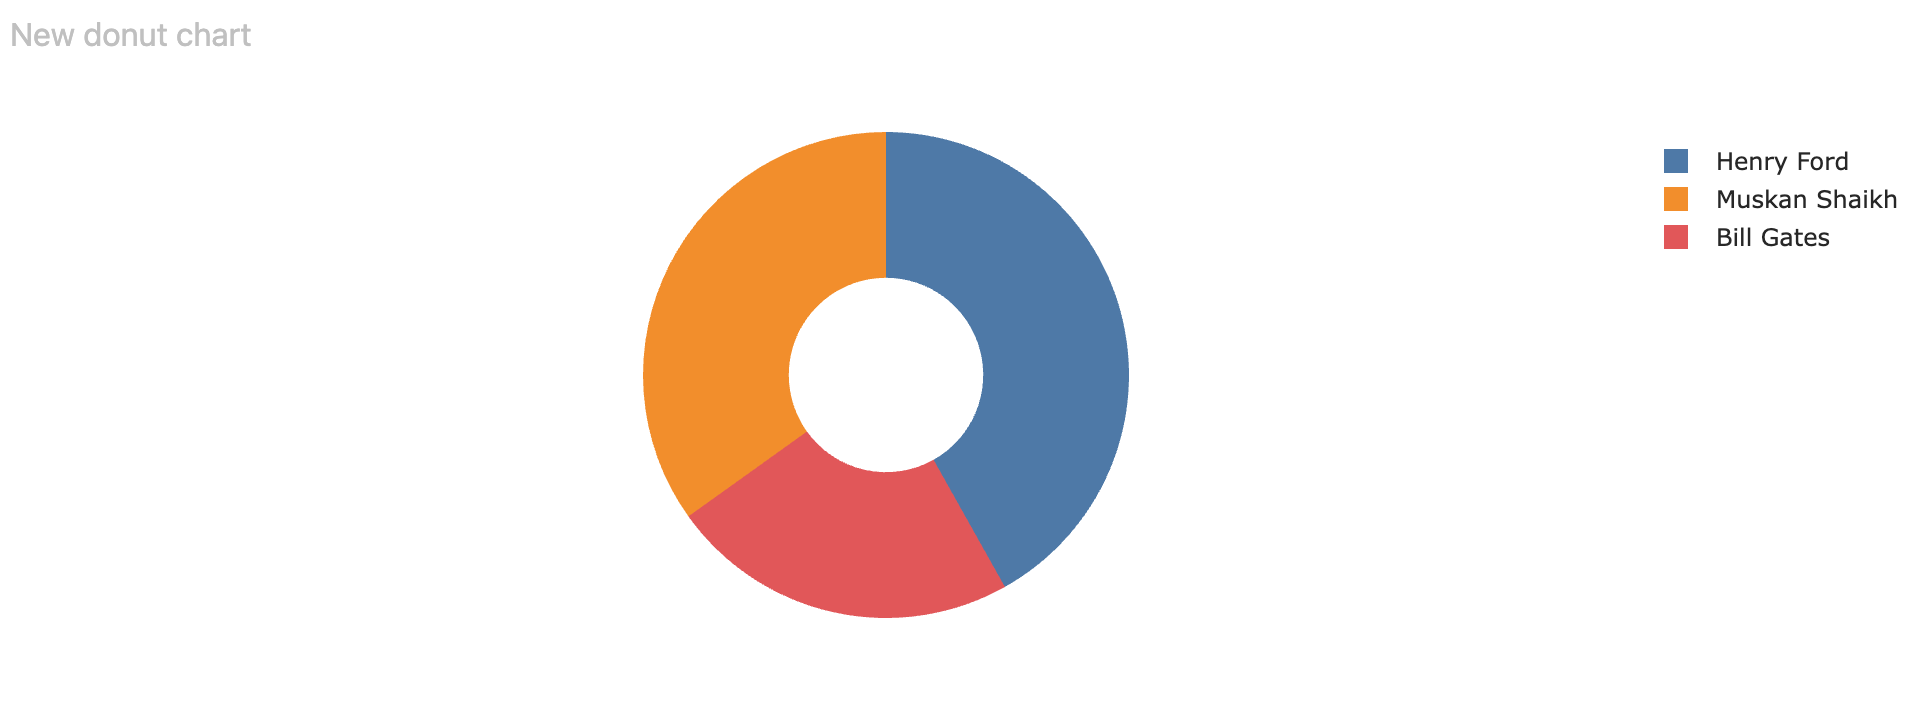

In [39]:
session.widget

In [40]:
session.link

http://localhost:9092

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

## What-if Analysis

In [41]:
import pandas as pd
from sqlalchemy import create_engine

In [42]:
connection_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

# Create the engine
engine = create_engine(connection_url)

In [43]:
product_df = pd.read_sql_query("SELECT * FROM dimproduct", engine)

In [44]:
product_df

,productkey,productaltkey,productname,productactualcost,productsalescost
0,1,ITM-001,Wheat Floor 1kg,5.5,6.5
1,2,ITM-002,Rice Grains 1kg,22.5,24.0
2,3,ITM-003,SunFlower Oil 1 ltr,42.0,43.5
3,4,ITM-004,Nirma Soap,18.0,20.0
4,5,ITM-005,Arial Washing Powder 1kg,135.0,139.0


In [45]:
better_actual_cost = {
    "ITM-001": 4.5,
    "ITM-002": 10,
    "ITM-003": 30,
    "ITM-004": 15,
    "ITM-005": 135,
}

In [46]:
for product, actual_cost in better_actual_cost.items():
    product_df.loc[
        product_df["productaltkey"] == product, "productactualcost"
    ] = actual_cost
product_df

,productkey,productaltkey,productname,productactualcost,productsalescost
0,1,ITM-001,Wheat Floor 1kg,4.5,6.5
1,2,ITM-002,Rice Grains 1kg,10.0,24.0
2,3,ITM-003,SunFlower Oil 1 ltr,30.0,43.5
3,4,ITM-004,Nirma Soap,15.0,20.0
4,5,ITM-005,Arial Washing Powder 1kg,135.0,139.0


In [47]:
product_table.scenarios["Lower actual cost"].load_pandas(product_df)